In [343]:
import pandas as pd
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime 
from statsmodels.tsa.stattools import adfuller
import datetime as dt
import statsmodels.api as sm

In [324]:
# load the data

od_data = pd.DataFrame()
for file_name in glob.glob("../Data/"+'OD_*.csv'):
    x = pd.read_csv(file_name, low_memory=False)
    od_data = pd.concat([od_data, x],axis=0)
    
stations_data = pd.DataFrame()
for file_name in glob.glob("../Data/"+'Stations_*.csv'):
    y = pd.read_csv(file_name, low_memory=False)
    stations_data = pd.concat([stations_data, y],axis=0)
    

deleted all the data after 2017-08-31 23:59
and selected only trips from station 6184 to station 6015

In [325]:
od_data = od_data[od_data.end_date < '2017-08-31 23:59']

filter_station = (od_data.start_station_code == 6184) & (od_data.end_station_code == 6015)
od_data = od_data[filter_station]

calculate daily metric of hiring 

In [414]:
od_data['start_date'] = od_data.start_date.astype('datetime64[ns]')
od_data['date'] = od_data.start_date.dt.date
od_data['hours'] = od_data.start_date.dt.hour
od_data['date_hours'] = od_data.start_date.round('60min')

trips_daily_count = (pd.DataFrame(od_data.groupby('date').start_date.count().rename('total'))
    .join(od_data[od_data.is_member == 1].groupby('date').start_date.count().rename('members'))
    .join(od_data[od_data.is_member == 0].groupby('date').start_date.count().rename('non_members'))
               .reset_index().fillna(value = 0)  )


# also check if hourly prediction is possible

check if some days were missed

In [415]:
trips_daily_count.date.sort_values()
trips_daily_count['missed_day'] = (trips_daily_count.date.shift(1) + datetime.timedelta(days=1)
                                   == trips_daily_count.date)
trips_daily_count[~trips_daily_count.missed_day].date.count()

94

generated all dates and fiiled days' gaps

In [416]:
all_dates = pd.date_range(dt.date(2014,1,1), dt.date(2017,9,1),freq='d')
trips_daily_count.date = trips_daily_count.date.astype('datetime64[ns]')

all_days = (all_dates.to_frame().rename(columns = {0 : 'date'})
                .merge(trips_daily_count, on = 'date', how = 'left')
                .fillna(0))[['date', 'total', 'members', 'non_members']]

data visualisation

Text(0.5, 1.0, 'Number of times they got the bikes')

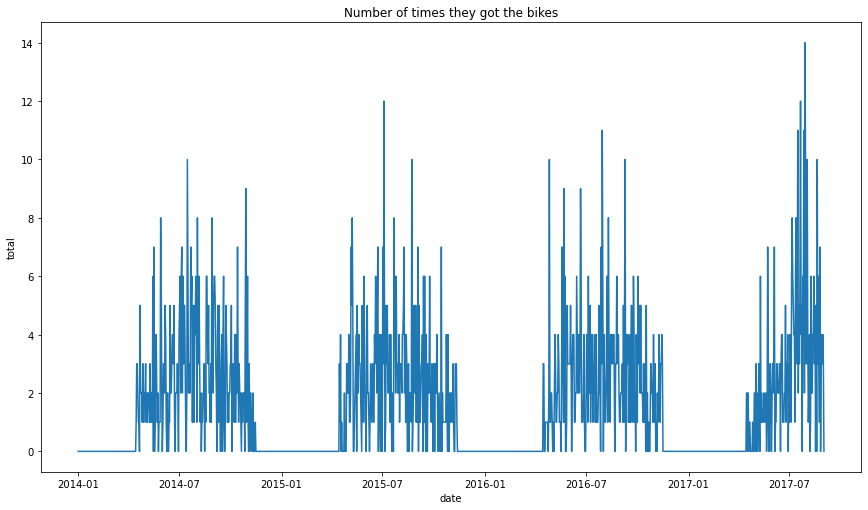

In [417]:
a4_dims = (14.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

#sns.lineplot(x ='date', y = 'members', data = trips_daily_count)
#sns.lineplot(x ='date', y = 'non_members', data = trips_daily_count)
sns.lineplot(x ='date', y = 'total', data = all_days )            
plt.title('Number of times they got the bikes')


We have sesonal data, not stationary 

In [418]:
all_days['days'] = all_days.date.dt.strftime('%m-%d')

In [419]:
train = all_days[all_days.date < '2017-01-01']
test = all_days[all_days.date > '2017-01-01']

reduce yearly sesonality

In [423]:
totals = (pd.DataFrame(train.groupby('days').total.mean().rename('mean_hire'))
        .join(train.groupby('days').total.max().rename('max_hire'))
        .join(train.groupby('days').total.min().rename('min_hire'))).reset_index()

totals_test = (pd.DataFrame(test.groupby('days').total.mean().rename('mean_hire'))
        .join(test.groupby('days').total.max().rename('max_hire'))
        .join(test.groupby('days').total.min().rename('min_hire'))).reset_index()

In [424]:
totals = totals[(totals.days > '04-14') & (totals.days < '11-15')]
total_test = totals_test[(totals_test.days > '04-14') & (totals_test.days < '09-01')]

In [425]:
totals.head(2)

,days,mean_hire,max_hire,min_hire
105,04-15,2.333333,3.0,1.0
106,04-16,2.333333,3.0,1.0


normalisation

In [426]:
totals['mean_stationary'] = totals.mean_hire.diff().fillna(0)
total_test['mean_stationary'] = totals_test.mean_hire.diff().fillna(0)

/var/folders/9t/5gcr47m91839pxy0fm6mhjw00000gn/T/ipykernel_64105/2694727652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_test['mean_stationary'] = totals_test.mean_hire.diff().fillna(0)


<AxesSubplot:>

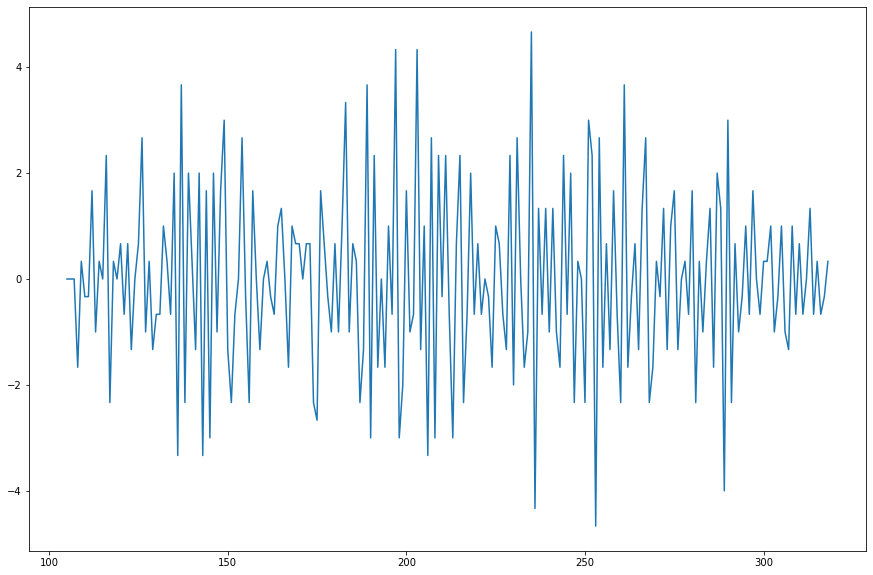

In [427]:
plt.figure(figsize = (15, 10))
totals.mean_stationary.plot()


In [428]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(totals.mean_stationary)

In [429]:
pvalue

6.724367716243541e-11

### !! stacionary!!! but still seosonal

/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


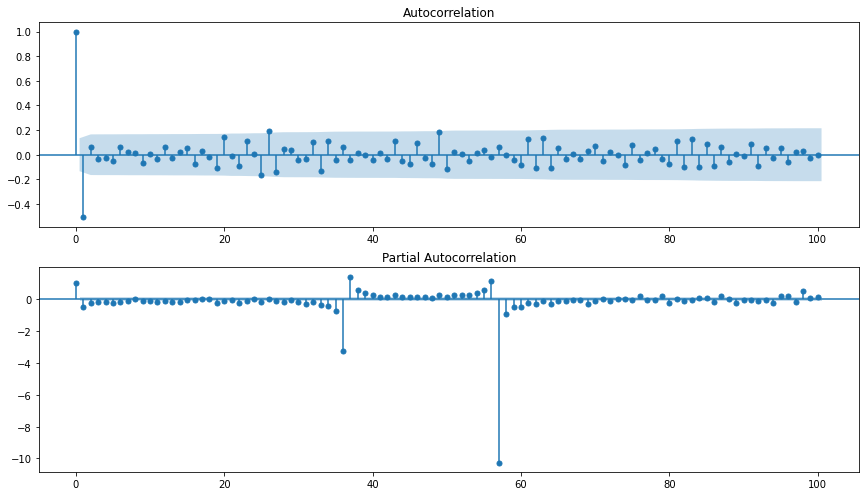

In [442]:
import statsmodels.api as sm

a4_dims = (14.7, 8.27)
fig, ax = plt.subplots(2,1, figsize=a4_dims)
fig = sm.graphics.tsa.plot_acf(totals.mean_stationary, lags = 100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(totals.mean_stationary, lags = 100, ax=ax[1])
plt.show()

/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obs

Optimization terminated successfully.
         Current function value: 1.627691
         Iterations: 4
         Function evaluations: 170


/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


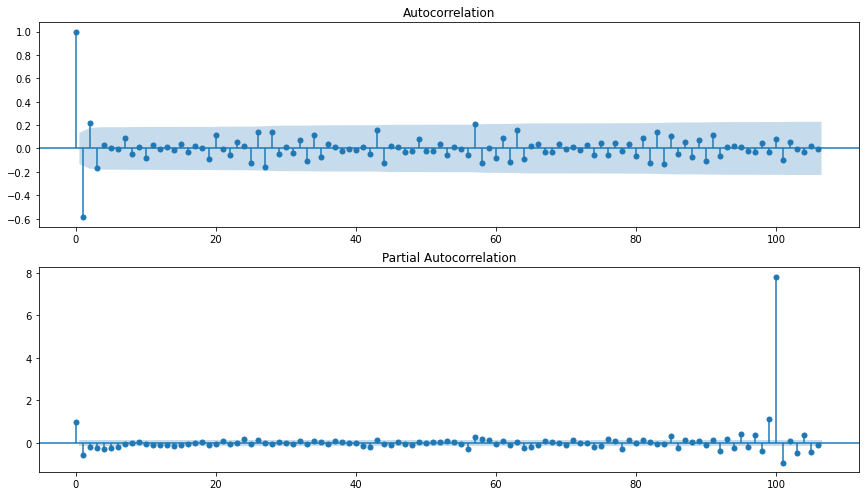

In [443]:
model = (sm.tsa.statespace.SARIMAX(totals.mean_stationary, order=(0,1,1), seasonal_order = (0,1,1,58))
         .fit(max_iter=20, method='powell'))
res = model.resid
fig, ax = plt.subplots(2,1, figsize=a4_dims)
fig = sm.graphics.tsa.plot_acf(res, lags=106, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=106, ax=ax[1])
plt.show()

 sarima parameters (1, 1, 1),(0, 1, 1, 100)

In [445]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(totals.mean_stationary,order=(1, 1, 1),seasonal_order=(0,1,1,100))
results1=model.fit()

/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22493D+00    |proj g|=  1.05159D-01

At iterate    5    f=  1.18057D+00    |proj g|=  1.51312D-02

At iterate   10    f=  1.16652D+00    |proj g|=  1.24318D-02

At iterate   15    f=  1.16562D+00    |proj g|=  5.68527D-03

At iterate   20    f=  1.16549D+00    |proj g|=  5.65889D-04

At iterate   25    f=  1.16547D+00    |proj g|=  3.24192D-04

At iterate   30    f=  1.16547D+00    |proj g|=  2.27552D-04

At iterate   35    f=  1.16547D+00    |proj g|=  3.09872D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:>

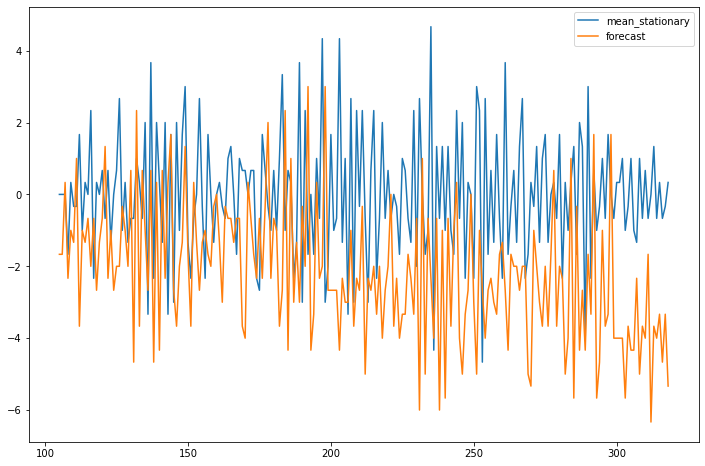

In [446]:
totals['forecast']=results1.predict(start=100,end=320,dynamic= True)
totals[['mean_stationary','forecast']].plot(figsize=(12,8))

/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:>

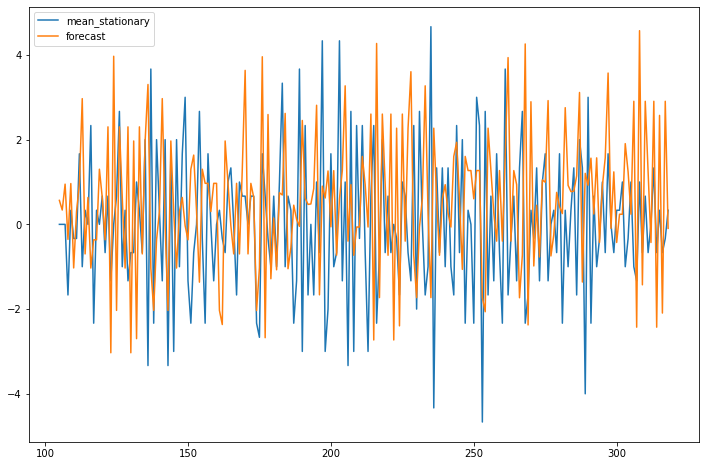

In [444]:
totals['forecast']=results.predict(start=100,end=320,dynamic= True)
totals[['mean_stationary','forecast']].plot(figsize=(12,8))


In [ ]:
pred = (pd.date_range(dt.date(2017,9,1), dt.date(2017,9,10),freq='d')
            .to_frame().rename(columns = {0:'days'}).days.dt.strftime('%m-%d').to_frame())

/Users/anna/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


(100.0, 160.0)

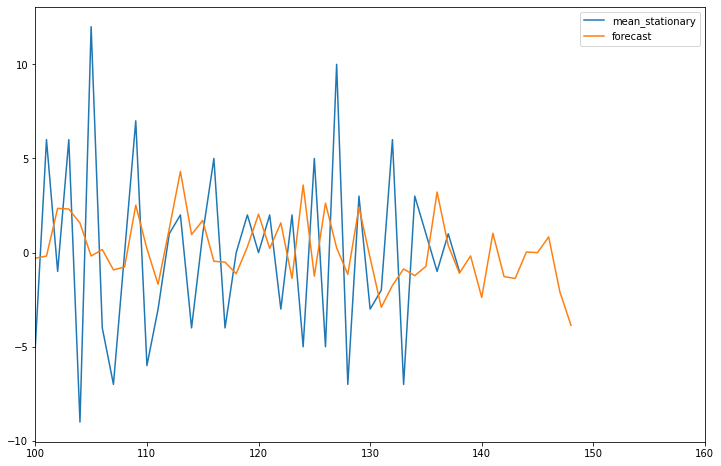

In [383]:
pred['forecast']=results.predict(start = 100,end = 500,dynamic= False)
pred[['mean_stationary','forecast']].plot(figsize=(12,8))

plt.xlim(100, 160)

In [361]:
pred = (pd.date_range(dt.date(2017,9,1), dt.date(2017,9,10),freq='d')
            .to_frame().rename(columns = {0:'days'}).days.dt.strftime('%m-%d').to_frame())

In [378]:
pred['forecast_inverse'] = totals_test.mean_hire[0] + pred.forecast.cumsum()
pred[['days', 'forecast_inverse']].tail(10)

,days,forecast_inverse
139,09-01,2.656562
140,09-02,2.719073
141,09-03,5.433339
142,09-04,5.133341
143,09-05,2.793488
144,09-06,4.505012
145,09-07,4.517588
146,09-08,3.153396
147,09-09,3.201884
148,09-10,3.624503
